In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Oversampling
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("merged/merged_data.csv", low_memory=False)
display(df.head())
print(df.columns)
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True)*100)


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0


Index(['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'], dtype='object')
label
2.0    8540583
0.0    2162246
1.0     806222
Name: count, dtype: int64
label
2.0    74.207535
0.0    18.787353
1.0     7.005113
Name: proportion, dtype: float64


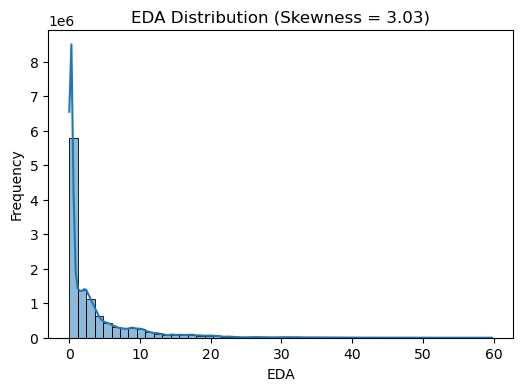

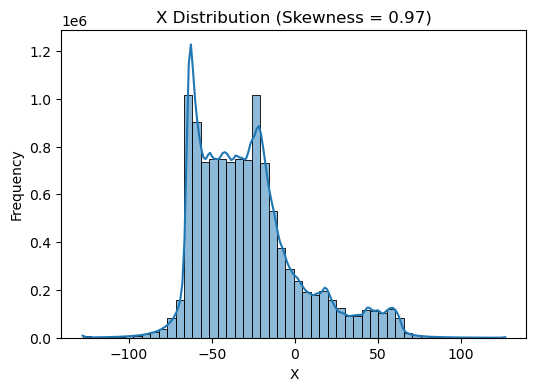

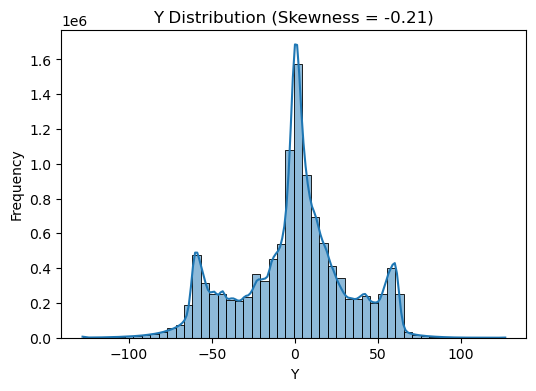

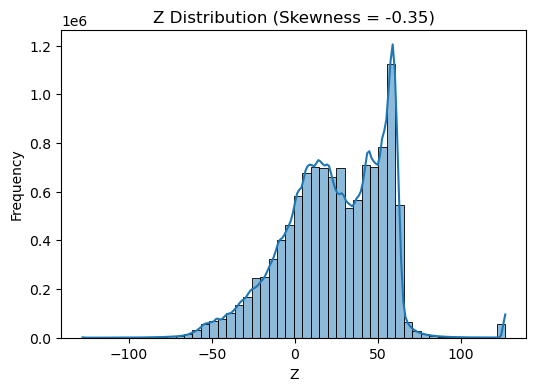

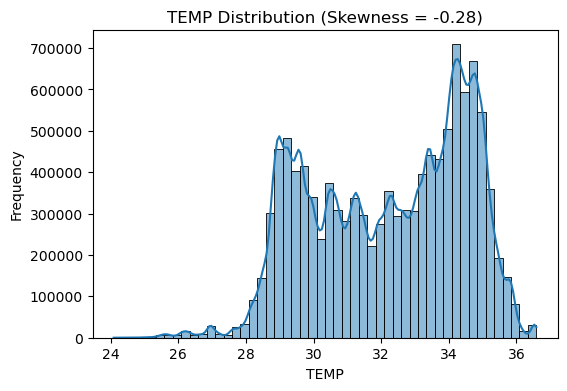

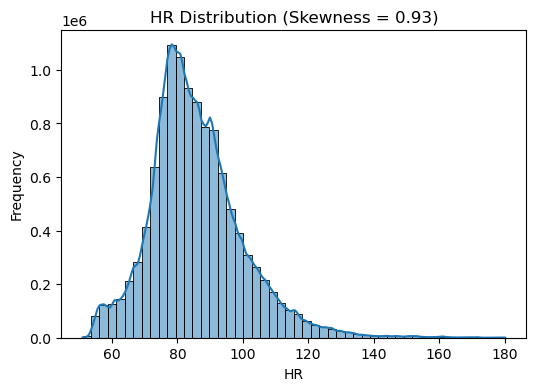

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns



for col in  ['EDA','X','Y','Z','TEMP','HR']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"{col} Distribution (Skewness = {df[col].skew():.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])  # replace 'timestamp' with your column name
df = df.set_index('datetime')
df


,X,Y,Z,EDA,HR,TEMP,id,label
datetime,,,,,,,,
2020-07-08 14:03:00.000000000,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2.0
2020-07-08 14:03:00.031249920,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2.0
2020-07-08 14:03:00.062500096,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2.0
2020-07-08 14:03:00.093750016,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2.0
2020-07-08 14:03:00.124999936,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2.0
...,...,...,...,...,...,...,...,...
2020-07-23 17:28:59.875000064,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2.0
2020-07-23 17:28:59.906249984,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2.0
2020-07-23 17:28:59.937499904,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2.0


In [5]:
from scipy.stats import mode
import numpy as np

def mode_agg(series):
    m = mode(series, nan_policy='omit')
    if isinstance(m.mode, np.ndarray):
        return m.mode[0] if len(m.mode) > 0 else np.nan
    else:
        return m.mode

# Group by 'id' and resample only on timestamps that exist
agg_list = []

for id_val, group in df.groupby('id'):
    # Resample only if group has a timestamp index
    grp_resampled = group.resample('1min').agg({
        'X': 'mean',
        'Y': 'mean',
        'Z': 'mean',
        'EDA': 'mean',
        'HR': 'mean',
        'TEMP': 'mean',
        'label': mode_agg
    })
    # Drop intervals with no data (all NaNs)
    grp_resampled = grp_resampled.dropna(subset=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP'])
    grp_resampled['id'] = id_val
    agg_list.append(grp_resampled)

# Combine all groups
agg_df = pd.concat(agg_list).reset_index()

print(agg_df.head())


             datetime          X         Y          Z       EDA         HR  \
0 2020-07-08 13:09:00 -49.991146 -2.661458  26.547396  2.229548  73.306167   
1 2020-07-08 13:10:00 -50.290625 -2.547396  36.003646  3.648911  69.256833   
2 2020-07-08 13:11:00 -47.184896 -4.267188  34.771875  3.568696  76.615667   
3 2020-07-08 13:12:00 -39.536979 -8.087500  33.094271  4.013080  77.727333   
4 2020-07-08 13:13:00 -44.123438 -5.307812  41.498958  4.545269  70.472167   

        TEMP  label  id  
0  32.438667    2.0  15  
1  32.571500    2.0  15  
2  32.664167    2.0  15  
3  32.595833    2.0  15  
4  32.610667    2.0  15  


In [6]:
numeric_cols=['X','Y','TEMP','HR','EDA','Z']
skew_vals = agg_df[numeric_cols].skew()
high_skew = skew_vals[abs(skew_vals) > 1].index
print("Highly skewed columns:", list(high_skew))


from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')  # works for negative & positive values
agg_df[high_skew] = pt.fit_transform(agg_df[high_skew])


skew_vals = agg_df[numeric_cols].skew()
high_skew = skew_vals[abs(skew_vals) > 1].index
print("Highly skewed columns:", list(high_skew))

Highly skewed columns: ['X', 'EDA']
Highly skewed columns: []


In [7]:
print(agg_df['label'].value_counts())


print(agg_df['label'].value_counts(normalize=True) * 100)


label
2.0    4568
0.0    1164
1.0     419
Name: count, dtype: int64
label
2.0    74.264347
0.0    18.923752
1.0     6.811901
Name: proportion, dtype: float64


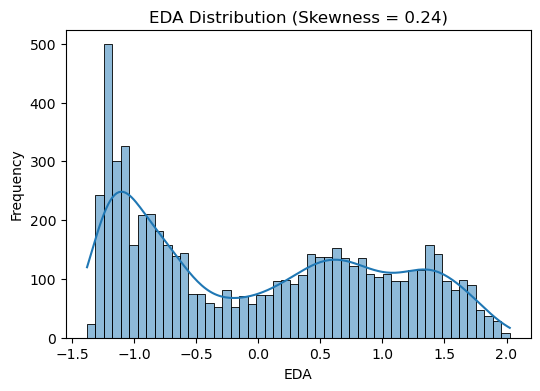

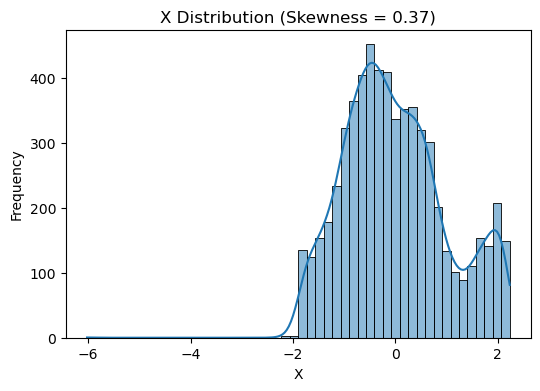

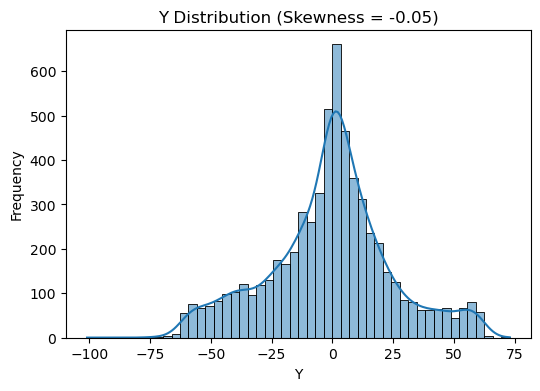

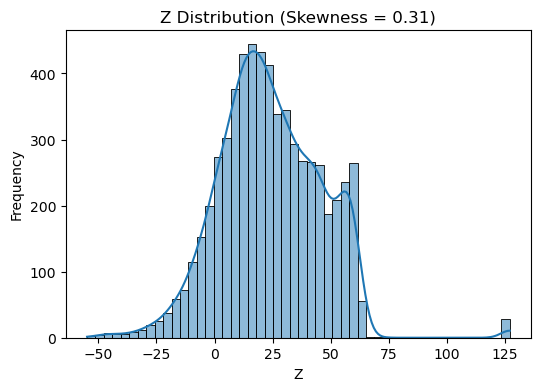

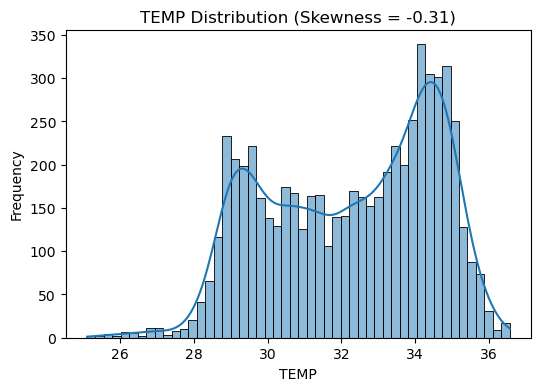

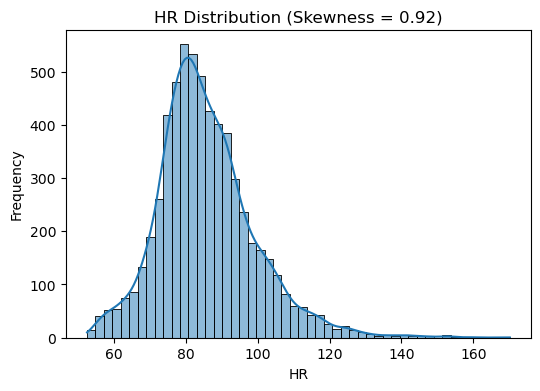

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns



for col in  ['EDA','X','Y','Z','TEMP','HR']:
    plt.figure(figsize=(6,4))
    sns.histplot(agg_df[col], kde=True, bins=50)
    plt.title(f"{col} Distribution (Skewness = {agg_df[col].skew():.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [9]:
X = agg_df.drop(["label","id","datetime"], axis=1)
y = agg_df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

print("Shapes:", X_train.shape, X_test.shape)


Shapes: (10963, 6) (2741, 6)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ Define model
model = LogisticRegression(max_iter=2000)

# ✅ Parameter grid suitable for multi-class
params = {
    "C": [0.01, 0.1, 1, 10],
    
    # Solver must match multi_class option — so we combine both
    "solver": ["liblinear", "lbfgs"],
    
    # Important for multi-class
    "multi_class": ["ovr", "multinomial"]
}

# ✅ GridSearch
log_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
log_grid.fit(X_train, y_train)

# ✅ Best model
log_best = log_grid.best_estimator_

# ✅ Accuracy
train_acc = accuracy_score(y_train, log_best.predict(X_train))
test_acc = accuracy_score(y_test, log_best.predict(X_test))

print("Best Params:", log_grid.best_params_)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# ✅ Evaluation
print("\nClassification Report:")
print(classification_report(y_test, log_best.predict(X_test)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, log_best.predict(X_test)))


Best Params: {'C': 1, 'multi_class': 'ovr', 'solver': 'lbfgs'}
Train Accuracy: 0.3992520295539542
Test Accuracy: 0.4035023713973003

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.46      0.45       913
         1.0       0.37      0.23      0.28       914
         2.0       0.39      0.53      0.45       914

    accuracy                           0.40      2741
   macro avg       0.40      0.40      0.39      2741
weighted avg       0.40      0.40      0.39      2741


Confusion Matrix:
[[416 181 316]
 [283 210 421]
 [257 177 480]]


In [13]:
model = SVC()
params = {
    "C":[0.1,1,10],
    "gamma":["scale","auto"]
}

svm_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_

print("Best Params:", svm_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, svm_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, svm_best.predict(X_test)))

print(classification_report(y_test, svm_best.predict(X_test)))
print(confusion_matrix(y_test, svm_best.predict(X_test)))


Best Params: {'C': 10, 'gamma': 'auto'}
Train Accuracy: 0.7683115935419137
Test Accuracy: 0.7435242612185334
              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       913
         1.0       0.79      0.82      0.81       914
         2.0       0.74      0.63      0.68       914

    accuracy                           0.74      2741
   macro avg       0.74      0.74      0.74      2741
weighted avg       0.74      0.74      0.74      2741

[[711  70 132]
 [ 89 750  75]
 [208 129 577]]


In [14]:
model = KNeighborsClassifier()
params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_

print("Best Params:", knn_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, knn_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, knn_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, knn_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, knn_best.predict(X_test)))


Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Train Accuracy: 1.0
Test Accuracy: 0.9106165632980664

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       913
         1.0       0.93      1.00      0.96       914
         2.0       0.99      0.74      0.85       914

    accuracy                           0.91      2741
   macro avg       0.92      0.91      0.91      2741
weighted avg       0.92      0.91      0.91      2741


Confusion Matrix:
 [[906   0   7]
 [  0 914   0]
 [167  71 676]]


In [15]:
model = RandomForestClassifier()
params = {
    "n_estimators": [100, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print("Best Params:", rf_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, rf_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, rf_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, rf_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_best.predict(X_test)))


Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Train Accuracy: 1.0
Test Accuracy: 0.9850419554906968

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       913
         1.0       1.00      1.00      1.00       914
         2.0       0.99      0.96      0.98       914

    accuracy                           0.99      2741
   macro avg       0.99      0.99      0.99      2741
weighted avg       0.99      0.99      0.99      2741


Confusion Matrix:
 [[908   0   5]
 [  0 914   0]
 [ 33   3 878]]


In [16]:
model = AdaBoostClassifier(algorithm="SAMME")   # ✅ Make it strong for multi-class

params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1]
}

ada_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
ada_grid.fit(X_train, y_train)

ada_best = ada_grid.best_estimator_

print("Best Params:", ada_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, ada_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, ada_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, ada_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, ada_best.predict(X_test)))


Best Params: {'learning_rate': 1, 'n_estimators': 200}
Train Accuracy: 0.5906230046520113
Test Accuracy: 0.5877417001094491

Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.67      0.65       913
         1.0       0.64      0.51      0.56       914
         2.0       0.51      0.59      0.55       914

    accuracy                           0.59      2741
   macro avg       0.59      0.59      0.59      2741
weighted avg       0.59      0.59      0.59      2741


Confusion Matrix:
 [[609  97 207]
 [144 463 307]
 [206 169 539]]


In [17]:
model = GradientBoostingClassifier()
params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5]
}

gb_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_

print("Best Params:", gb_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, gb_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, gb_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, gb_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, gb_best.predict(X_test)))


Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Train Accuracy: 0.9772872388944632
Test Accuracy: 0.9452754469171835

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       913
         1.0       0.97      1.00      0.99       914
         2.0       0.97      0.87      0.92       914

    accuracy                           0.95      2741
   macro avg       0.95      0.95      0.94      2741
weighted avg       0.95      0.95      0.94      2741


Confusion Matrix:
 [[881   5  27]
 [  0 914   0]
 [ 96  22 796]]


In [18]:
model = ExtraTreesClassifier()
params = {
    "n_estimators": [100, 300],
    "max_depth": [10, 20, None]
}

et_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
et_grid.fit(X_train, y_train)
et_best = et_grid.best_estimator_

print("Best Params:", et_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, et_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, et_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, et_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, et_best.predict(X_test)))


Best Params: {'max_depth': None, 'n_estimators': 300}
Train Accuracy: 1.0
Test Accuracy: 0.9934330536300621

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       913
         1.0       1.00      1.00      1.00       914
         2.0       0.99      0.99      0.99       914

    accuracy                           0.99      2741
   macro avg       0.99      0.99      0.99      2741
weighted avg       0.99      0.99      0.99      2741


Confusion Matrix:
 [[908   0   5]
 [  0 914   0]
 [ 13   0 901]]


In [19]:
model = MLPClassifier(max_iter=500)
params = {
    "hidden_layer_sizes": [(64,32), (128,64)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
    "learning_rate": ["constant", "adaptive"]
}

mlp_grid = GridSearchCV(model, params, scoring="accuracy", cv=3, n_jobs=-1)
mlp_grid.fit(X_train, y_train)
mlp_best = mlp_grid.best_estimator_

print("Best Params:", mlp_grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, mlp_best.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, mlp_best.predict(X_test)))

print("\nClassification Report:\n", classification_report(y_test, mlp_best.predict(X_test)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, mlp_best.predict(X_test)))


Best Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant'}
Train Accuracy: 0.9985405454711301
Test Accuracy: 0.9485589201021525

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.95       913
         1.0       0.96      1.00      0.98       914
         2.0       0.99      0.85      0.92       914

    accuracy                           0.95      2741
   macro avg       0.95      0.95      0.95      2741
weighted avg       0.95      0.95      0.95      2741


Confusion Matrix:
 [[906   2   5]
 [  0 914   0]
 [ 97  37 780]]


In [20]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd

# ✅ K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Define models (Extra Trees Added ✅)
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),           # ✅ Added
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

results = {
    "Model": [],
    "Fold Scores": [],
    "Mean Accuracy": [],
    "Std Dev": []
}

# ✅ Evaluate each model
for name, model in models.items():
    scores = cross_val_score(model, X_res, y_res, cv=kf, scoring='accuracy')
    results["Model"].append(name)
    results["Fold Scores"].append(scores)
    results["Mean Accuracy"].append(scores.mean())
    results["Std Dev"].append(scores.std())

# ✅ Create table
results_df = pd.DataFrame(results)

print(results_df)


                 Model                                        Fold Scores  \
0  Logistic Regression  [0.39365195184239327, 0.3863553447646844, 0.39...   
1                  SVC  [0.6866107260124042, 0.6931776723823422, 0.674...   
2                  KNN  [0.8588106530463334, 0.8526085370302809, 0.850...   
3        Random Forest  [0.9795695001824152, 0.9821233126596133, 0.977...   
4          Extra Trees  [0.9886902590295512, 0.9861364465523531, 0.988...   
5             AdaBoost  [0.6063480481576067, 0.6099963516964612, 0.589...   
6    Gradient Boosting  [0.76541408245166, 0.7468077344035023, 0.73294...   
7       MLP Classifier  [0.7701568770521707, 0.7581174753739511, 0.750...   

   Mean Accuracy   Std Dev  
0       0.393171  0.008216  
1       0.687392  0.009386  
2       0.854933  0.004155  
3       0.979714  0.001608  
4       0.987887  0.001042  
5       0.600701  0.010934  
6       0.747591  0.012097  
7       0.763793  0.009225  


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

results = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Precision (weighted)": [],
    "Recall (weighted)": [],
    "F1-Score (weighted)": []
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results["Model"].append(name)
    results["Train Accuracy"].append(accuracy_score(y_train, y_train_pred))
    results["Test Accuracy"].append(accuracy_score(y_test, y_test_pred))
    results["Precision (weighted)"].append(
        precision_score(y_test, y_test_pred, average="weighted")
    )
    results["Recall (weighted)"].append(
        recall_score(y_test, y_test_pred, average="weighted")
    )
    results["F1-Score (weighted)"].append(
        f1_score(y_test, y_test_pred, average="weighted")
    )

# ✅ Create table
results_df = pd.DataFrame(results)
print("\nFINAL MODEL PERFORMANCE TABLE (NO AUC):\n")
print(results_df)



FINAL MODEL PERFORMANCE TABLE (NO AUC):

                 Model  Train Accuracy  Test Accuracy  Precision (weighted)  \
0  Logistic Regression        0.400620       0.405327              0.402043   
1                  SVC        0.698258       0.690259              0.690665   
2                  KNN        0.906869       0.862824              0.869039   
3        Random Forest        1.000000       0.987596              0.987798   
4          Extra Trees        1.000000       0.991244              0.991320   
5             AdaBoost        0.606951       0.595768              0.595858   
6    Gradient Boosting        0.772781       0.750456              0.753151   
7       MLP Classifier        0.804616       0.779642              0.777501   

   Recall (weighted)  F1-Score (weighted)  
0           0.405327             0.395751  
1           0.690259             0.690049  
2           0.862824             0.857167  
3           0.987596             0.987588  
4           0.991244      


✅ Model Accuracy Table:

                 Model  Accuracy
0  Logistic Regression  0.403502
1        Random Forest  0.985042
2                  SVM  0.743524
3                  KNN  0.910617
4          Extra Trees  0.993433
5             AdaBoost  0.587742
6    Gradient Boosting  0.945275
7       MLP Classifier  0.948559


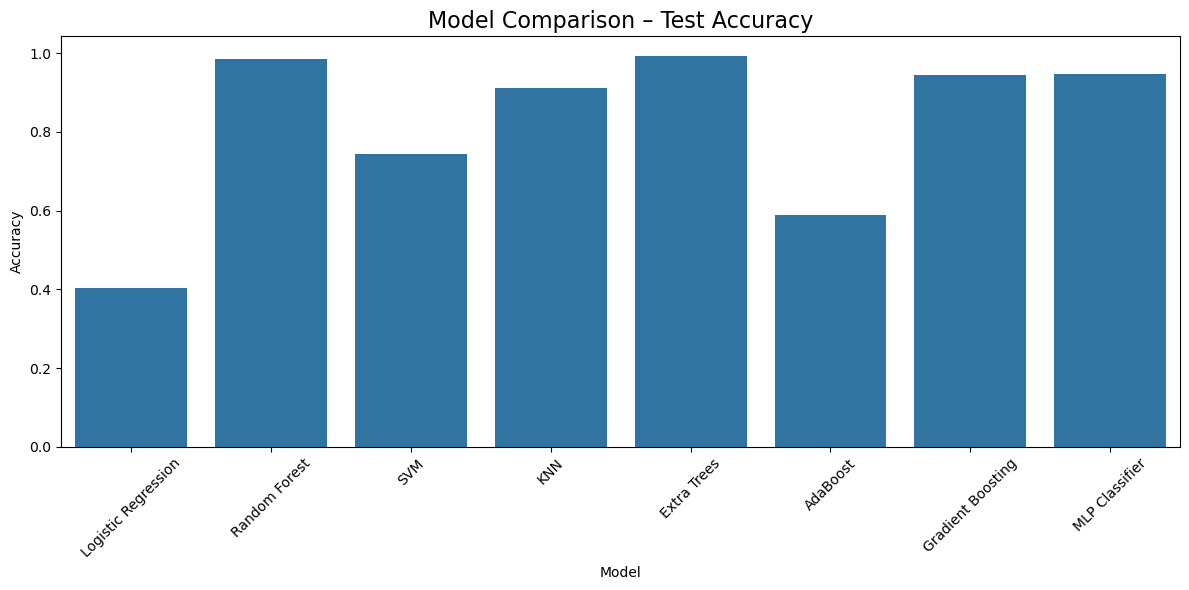

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import pandas as pd

# -------------------------------------------------------
# ✅ 1. STORE ALL REQUIRED MODELS IN A DICTIONARY
# -------------------------------------------------------
models = {
    "Logistic Regression": log_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "SVM": svm_grid.best_estimator_,
    "KNN": knn_grid.best_estimator_,
    "Extra Trees": et_grid.best_estimator_,
    "AdaBoost": ada_grid.best_estimator_,
    "Gradient Boosting": gb_grid.best_estimator_,
    "MLP Classifier": mlp_grid.best_estimator_,
}

# -------------------------------------------------------
# ✅ 2. CALCULATE TEST ACCURACIES
# -------------------------------------------------------
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append([name, acc])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])

print("\n✅ Model Accuracy Table:\n")
print(results_df)

# -------------------------------------------------------
# ✅ 3. BAR PLOT OF ACCURACIES
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Comparison – Test Accuracy", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Confusion Matrix:
 [[908   0   5]
 [  0 914   0]
 [ 13   0 901]]


<Figure size 600x500 with 0 Axes>

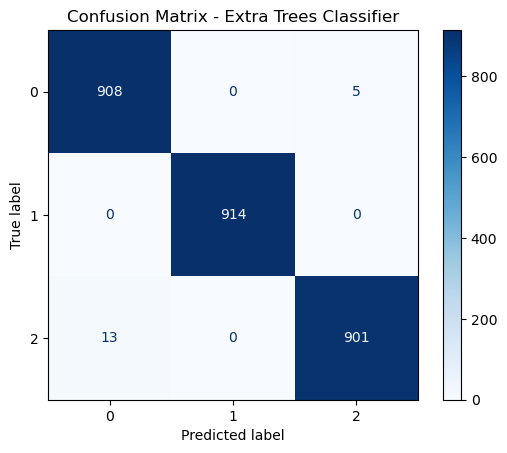

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get best model
et_best = et_grid.best_estimator_

# Predictions
y_pred = et_best.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Extra Trees Classifier")
plt.show()
